In [1]:
import sounddevice as sd
import soundfile as sf
import soundfile as sf
from scipy import signal 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
fs = 24000
window_size = 256
overlap = 0.875
noverlap = int(np.floor(window_size * overlap))

file_num = 11

filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64'
strength_filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64'

In [3]:
with open(filenm, 'rb') as f:  
    Audiodata, _samplerate_bad = sf.read(f)
    
mic  = Audiodata[:, 0]
acc_m = Audiodata[:, 1]
acc_f = Audiodata[:, 2]
del Audiodata

In [4]:
# Apply bandpass
sos = signal.butter(10, [15, 8000], 'bp', fs=24000, output='sos')
filtered_bp = signal.sosfilt(sos, mic)
#sf.write('/home/bukaya/ethz/ns/vocal-recon/mic11_butterworth_bp_10_15_8000.w64', filtered_bp, fs)

In [5]:
acc_m_bp = signal.sosfilt(sos, acc_m)

In [6]:
acc_f_bp = signal.sosfilt(sos, acc_f)

In [26]:
# Take moving window RMS
window = 2400
sq_fil = np.power(filtered_bp,2)
mean_pd_abs = pd.Series(sq_fil).rolling(window=window).mean().iloc[window-1:].values

(0, 2e-06)

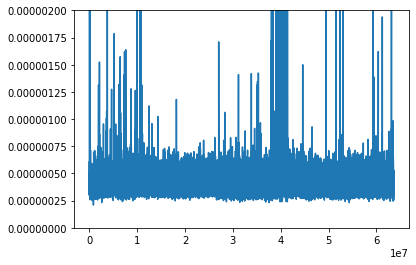

In [29]:
# Plot to choose threshold for silence (do this rarely, takes some seconds)
plt.plot(mean_pd_abs)
plt.ylim([0, 2e-6])

In [25]:
# This method of boolean indexing + where is the fastest I could find, much, much faster than using a for loop to check
# extract time indices where the microphone is louder than some threshold during the moving RMS window
mask = mean_pd_abs >= 3e-6
indices = np.where(mask)
# The moving RMS window is offset by window//2, because the first data point of RMS corresponds to that point
# also, indices is a tuple, the first value of which is our desired array.
indices = indices[0] + window //2
# Save data from all sources at the same time indices
mic_bp_np = filtered_bp[indices]
acc_m_np  = acc_m_bp[indices]
acc_f_np  = acc_f_bp[indices]
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/3_{file_num}_short_{window}_mic_alt.w64', mic_bp_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/3_{file_num}_short_{window}_acc_m_alt.w64', acc_m_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/3_{file_num}_short_{window}_acc_f_Alt.w64', acc_f_np, fs)

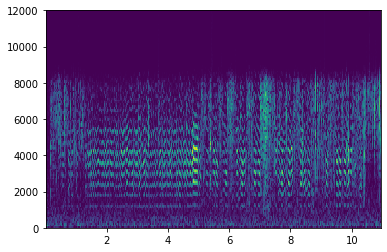

In [12]:
# Plot whole non-silence microphone
window_size = 240

f, t, Sxx = signal.spectrogram(mic_bp_np, fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

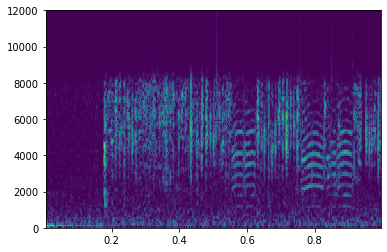

In [16]:
# Plot only a certain slice from microphone(here) and accelerometers(next)
window_size = 240
slc = slice(0,fs)
f, t, Sxx = signal.spectrogram(mic_bp_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

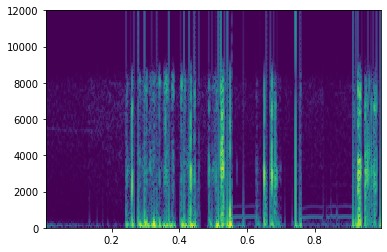

In [17]:
f, t, Sxx = signal.spectrogram(acc_f_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

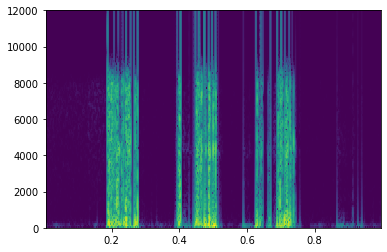

In [18]:
f, t, Sxx = signal.spectrogram(acc_m_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

# Old stuff

In [3]:
def getIndex(samplerate, seconds=0, minutes=0, hours=0):
    return samplerate*(seconds + minutes*60 + hours*3600)

In [4]:
def getTime(samplerate, index):
    s_idx = index / samplerate
    hours = s_idx // 3600
    minutes = (s_idx - hours*3600) // 60
    seconds = (s_idx - hours*3600 - minutes * 60)
    return [hours, minutes, seconds]

In [37]:
%%timeit
indices = mean_pd_abs >= 1e-6

46.2 ms ± 693 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
c = np.where(indices)

11 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
window = 2400
sq_fil = np.power(filtered_bp,2)
mean_pd_abs = pd.Series(sq_fil).rolling(window=window).mean().iloc[window-1:].values
plt.plot(mean_pd_abs)
plt.ylim([0,0.000003])

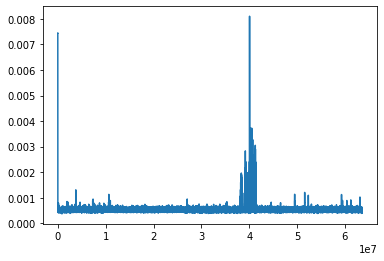

In [7]:
window = 2400
abs_fil = np.absolute(filtered_bp)
mean_pd_abs = pd.Series(abs_fil).rolling(window=window).mean().iloc[window-1:].values
plt.plot(mean_pd_abs)

In [22]:
%%time
counter = 0

mic_bp_sht = []
acc_m_sht = []
acc_f_sht = []

for i, j in enumerate(mean_pd_abs):
    if j >= 2e-6:
        mic_bp_sht.append(filtered_bp[i + window//2])
        acc_m_sht.append(acc_m[i + window//2])
        acc_f_sht.append(acc_f[i + window//2])
        counter += 1
        
print(counter)
mic_bp_np = np.asarray(mic_bp_sht)
acc_m_np = np.asarray(acc_m_sht)
acc_f_np = np.asarray(acc_f_sht)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_mic_.w64', mic_bp_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_acc_m.w64', acc_m_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_acc_f.w64', acc_f_np, fs)

262687
CPU times: user 15.4 s, sys: 61 µs, total: 15.4 s
Wall time: 15.4 s
